In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# Imports required for ANOVA
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi

import scipy
import itertools

import seaborn as sns

In [3]:
data = pd.read_csv("final_data.csv", low_memory=False)

In [4]:
data.head()

,Unnamed: 0,eventid,iyear,imonth,iday,approxdate,extended,country_txt,region_txt,provstate,...,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,hostkidoutcome_txt,nreleased,related
0,0,197000000001,1970,7,2,NaN,0,Dominican Republic,Central America & Caribbean,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,197000000002,1970,0,0,NaN,0,Mexico,North America,Federal,...,NaN,Mexico,1.0,800000.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,197001000001,1970,1,0,NaN,0,Philippines,Southeast Asia,Tarlac,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,197001000002,1970,1,0,NaN,0,Greece,Western Europe,Attica,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,197001000003,1970,1,0,NaN,0,Japan,East Asia,Fukouka,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Auxillary methods

In [5]:
# Additional function that finds all possible pairs in list
def find_pairs(values):
    return [(a, b) for a, b in itertools.permutations(values, 2)]

In [6]:
from functools import wraps
import errno
import os
import signal

class TimeoutError(Exception):
    pass

# Creates timeout annotation
def timeout(seconds=30, error_message=os.strerror(errno.ETIME)):
    def decorator(func):
        def _handle_timeout(signum, frame):
            raise TimeoutError(error_message)

        def wrapper(*args, **kwargs):
            signal.signal(signal.SIGALRM, _handle_timeout)
            signal.setitimer(signal.ITIMER_REAL,seconds) #used timer instead of alarm
            try:
                result = func(*args, **kwargs)
            finally:
                signal.alarm(0)
            return result
        return wraps(func)(wrapper)
    return decorator

In [7]:
# Removes rows from contingency table where some frequence is less than 5 or nan
def remove_infrequent_rows(table, treshold):
    result = table.copy(deep=True)
    for column in result.columns:
        result = result.dropna(how="any")
        #esult = result[result[column] != np.nan
        result = result[result[column] > 5]
    if (result.shape[0] / np.float64(table.shape[0])) < treshold:
        return None
    else:
        return result

In [8]:
def remove_infrequent_rows_with_categoricals(table, treshold):
    result = table.copy(deep=True)
    for column in result.columns:
        result = result.dropna(how="any")
        #result = result[result[column] != np.nan
        #result = result[result[column] > 5]
    if (result.shape[0] / np.float64(table.shape[0])) < treshold:
        return None
    else:
        return result

In [9]:
# Calculates chi square for all pairs in the list
# Input: possible_pairs -> list of tuples, containing names of possible column pairs
#        data -> pandas.DataFrame that has the columns to be analysed
#        column -> String with the name of the column, whose dependance is to be measured
# Return: void
# Result: prints all chi-square test results
def calculate_chi_square_for_column(possible_pairs, data, column, treshold):
    print("Total pairs: ", len(possible_pairs))
    for i in range(len(possible_pairs)):
        pair = possible_pairs[i]
        if column in pair:
            print("Current pair: ", i, ") ", pair)
            subset = data[[pair[0], pair[1]]]
            contingency_table = pd.crosstab(subset[pair[0]], subset[pair[1]])
            contingency_table = remove_infrequent_rows(contingency_table, treshold)
            
            # Does not calculate chi-square if the ammount of removed rows is greater than 40%
            if not isinstance(contingency_table, pd.DataFrame):
                print("Insufficient data for analysis")
                continue
            if contingency_table.empty:
                print("Insufficient data for analysis")
                continue
            print()
            print(contingency_table)
            chi = scipy.stats.chi2_contingency(contingency_table)
            print(chi)
            print()

In [10]:
# Performs a one-way ANOVA test to find whether the values in two columns are independent or not
def perform_anova_for_column(possible_pairs, data, column, treshold):
    print("Total pairs: ", len(possible_pairs))
    for i in range(len(possible_pairs)):
        pair = possible_pairs[i]
        if column in pair:
            print("Current pair: ", i, ") ", pair)
            subset = data[[pair[0], pair[1]]]
            subset = remove_infrequent_rows_with_categoricals(subset, treshold)
            
            if not isinstance(subset, pd.DataFrame):
                print("Insufficient data for analysis")
                continue
            if subset.empty:
                print("Insufficient data for analysis")
                continue
            print()
            formula = (str(pair[0] + "~" + str(pair[1])))
            model = smf.ols(formula=formula, data=subset)
            results = model.fit()
            
            message = ""
            @timeout(90)
            def print_results(results):
                try:
                    if results.fvalue > 50 and results.f_pvalue < 0.05 and results.f_pvalue != 0:
                        return results.summary()
                    else:
                        return "The F-statistic and p-value are too low"
                except:
                    try:
                        subset = subset.astype("category")
                        model = smf.ols(formula=formula, data=subset)
                        results = model.fit()
                        if results.fvalue > 30 and results.f_pvalue < 0.05 and results.f_pvalue != 0:
                            return results.summary()
                        else:
                            return "The F-statistic and p-value are too low"
                    except:
                        return "Could not calculate ANOVA results"
            
            message = print_results(results)
            if message == "":
                print("Calculations took too much time")
            else:
                print(message)
            print() 

# More data preparation

In [11]:
# Function that turns attack type to more beautiful str
def beautify_attacktype(s):
    def remove_commas(s):
        while s.endswith(", "):
            s = s[:-2]
        return s
    parts = s.split(",")
    result = ""
    for part in parts:
        if "nan" not in part.strip():
            result += part.strip() + ", "
    
    return remove_commas(result)

In [12]:
# Creates new column by combining three attactype_txt columns and adds it to the dataset as attcktype_txt
new_column = pd.Series(data.attacktype1_txt.astype(str) + ', ' +  data.attacktype2_txt.astype(str) + ', ' + data.attacktype3_txt.astype(str))
data = data.assign(attacktype_txt=new_column.values)
data.attacktype_txt = data.attacktype_txt.apply(beautify_attacktype)

# Encodes attacktype_txt to category type
data.attacktype_txt = data.attacktype_txt.astype("category")
data.attacktype_txt.value_counts().head()

Bombing/Explosion                 86079
Armed Assault                     40927
Assassination                     19190
Facility/Infrastructure Attack    10168
Hostage Taking (Kidnapping)        9423
Name: attacktype_txt, dtype: int64

# Divide data into two parts: before and after 1997

In [15]:
data_old = data[data.iyear < 1997].copy(deep=True)

In [16]:
data_old.describe()

,Unnamed: 0,eventid,iyear,imonth,iday,extended,latitude,longitude,specificity,vicinity,...,nhostkid,nhostkidus,nhours,ndays,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,nreleased
count,64310.000000,6.431000e+04,64310.000000,64310.000000,64310.000000,64310.000000,60889.000000,6.088800e+04,64310.000000,64310.000000,...,3879.000000,3877.000000,1312.000000,1042.000000,63936.000000,6.290000e+02,1.0,1.540000e+02,4.000000,1186.000000
mean,32154.500000,1.986419e+11,1986.353180,6.457176,15.401773,0.018364,18.017570,-1.429308e+03,1.429498,0.038097,...,2.717711,0.078153,0.837652,28.729367,0.010088,3.492041e+06,20000.0,1.325981e+06,16581.250000,7.468803
std,18564.842243,6.229994e+08,6.229454,3.398759,8.801756,0.134265,24.561747,3.492772e+05,1.107537,0.191431,...,351.835431,3.787483,3.993611,129.837568,0.099933,4.066911e+07,NaN,4.715787e+06,19943.705931,35.285447
min,0.000000,1.970000e+11,1970.000000,0.000000,0.000000,0.000000,-53.154613,-8.618590e+07,1.000000,0.000000,...,-99.000000,-99.000000,0.000000,0.000000,0.000000,0.000000e+00,20000.0,0.000000e+00,0.000000,-99.000000
25%,16077.250000,1.982043e+11,1982.000000,4.000000,8.000000,0.000000,5.222845,-7.587190e+01,1.000000,0.000000,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,20000.0,0.000000e+00,0.000000,1.000000
50%,32154.500000,1.987092e+11,1987.000000,6.000000,15.000000,0.000000,14.866667,-5.661926e+00,1.000000,0.000000,...,1.000000,0.000000,0.000000,3.000000,0.000000,1.250000e+04,20000.0,3.585000e+04,13162.500000,1.000000
75%,48231.750000,1.991093e+11,1991.000000,9.000000,23.000000,0.000000,38.388443,3.471268e+01,1.000000,0.000000,...,3.000000,0.000000,0.000000,12.000000,0.000000,5.000000e+05,20000.0,4.770000e+05,29743.750000,3.000000
max,64309.000000,1.996123e+11,1996.000000,12.000000,31.000000,1.000000,64.837778,1.784419e+02,5.000000,1.000000,...,17000.000000,70.000000,72.000000,2454.000000,1.000000,1.000000e+09,20000.0,4.100000e+07,40000.000000,390.000000


In [17]:
data_new = data[data.iyear >= 1997].copy(deep=True)

In [18]:
data_new.describe()

,Unnamed: 0,eventid,iyear,imonth,iday,extended,latitude,longitude,specificity,vicinity,...,nhostkid,nhostkidus,nhours,ndays,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,nreleased
count,117381.000000,1.173810e+05,117381.000000,117381.000000,117381.000000,117381.000000,116246.000000,116246.000000,117375.000000,117346.000000,...,9693.000000,9640.000000,609.000000,2827.000000,12047.000000,6.730000e+02,5.620000e+02,6.200000e+02,548.000000,9214.000000
mean,123000.000000,2.011628e+11,2011.561573,6.472811,15.562553,0.060129,26.369141,49.697266,1.463480,0.087553,...,5.259775,-0.527801,3.739327,44.975593,0.054287,3.100187e+06,5.794803e+05,5.669151e+05,121.102190,-33.714782
std,33885.120311,5.093657e+08,5.094114,3.382563,8.820289,0.237727,13.618503,38.354840,0.928067,0.282645,...,88.213023,7.723114,5.282431,148.237273,0.226593,1.690471e+07,7.084190e+06,1.108547e+07,2136.396177,67.242528
min,64310.000000,1.997010e+11,1997.000000,1.000000,0.000000,0.000000,-42.884049,-124.224996,1.000000,0.000000,...,-99.000000,-99.000000,0.000000,0.000000,0.000000,-9.900000e+01,-9.900000e+01,-9.900000e+01,-99.000000,-99.000000
25%,93655.000000,2.009092e+11,2009.000000,4.000000,8.000000,0.000000,15.325443,36.821107,1.000000,0.000000,...,1.000000,0.000000,1.000000,2.000000,0.000000,-9.900000e+01,0.000000e+00,-9.900000e+01,0.000000,-99.000000
50%,123000.000000,2.013110e+11,2013.000000,6.000000,15.000000,0.000000,32.469238,44.621403,1.000000,0.000000,...,2.000000,0.000000,2.000000,5.000000,0.000000,2.439603e+04,0.000000e+00,-9.900000e+01,0.000000,0.000000
75%,152345.000000,2.015083e+11,2015.000000,9.000000,23.000000,0.000000,34.346722,70.759615,1.000000,0.000000,...,5.000000,0.000000,4.000000,21.000000,0.000000,3.087375e+05,0.000000e+00,0.000000e+00,0.000000,1.000000
max,181690.000000,2.017123e+11,2017.000000,12.000000,31.000000,1.000000,74.633553,179.366667,5.000000,1.000000,...,5350.000000,86.000000,24.000000,2078.000000,1.000000,2.000000e+08,1.320000e+08,2.750000e+08,48000.000000,2769.000000


# Identifying important correlations for the attack types

### First attack type

In [63]:
data.attacktype1_txt.value_counts()

Bombing/Explosion                      88255
Armed Assault                          42669
Assassination                          19312
Hostage Taking (Kidnapping)            11158
Facility/Infrastructure Attack         10356
Unknown                                 7276
Unarmed Assault                         1015
Hostage Taking (Barricade Incident)      991
Hijacking                                659
Name: attacktype1_txt, dtype: int64

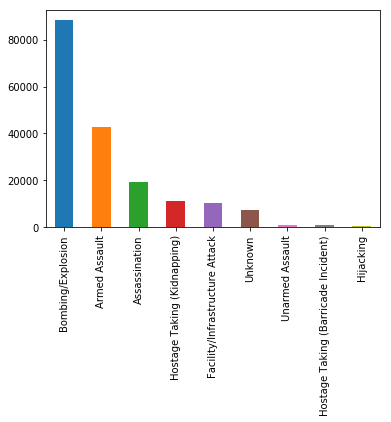

In [49]:
data.attacktype1_txt.value_counts().plot(kind="bar")

In [52]:
data[data["iyear"] < 1997].attacktype1_txt.value_counts()

Bombing/Explosion                      27077
Armed Assault                          14795
Assassination                          11860
Facility/Infrastructure Attack          4374
Hostage Taking (Kidnapping)             2673
Unknown                                 2261
Hostage Taking (Barricade Incident)      620
Unarmed Assault                          330
Hijacking                                320
Name: attacktype1_txt, dtype: int64

### Second attack type

In [65]:
data.attacktype2_txt.value_counts()

Armed Assault                          3434
Facility/Infrastructure Attack         1653
Bombing/Explosion                       506
Hostage Taking (Kidnapping)             479
Assassination                           162
Hostage Taking (Barricade Incident)      37
Unarmed Assault                          30
Hijacking                                10
Unknown                                   3
Name: attacktype2_txt, dtype: int64

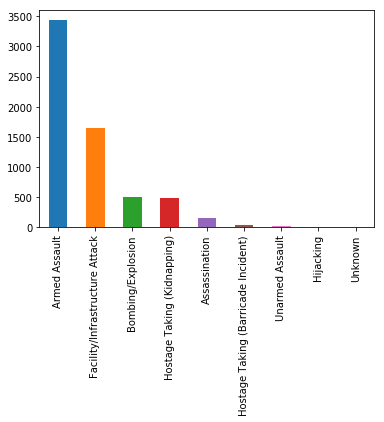

In [66]:
data.attacktype2_txt.value_counts().plot(kind="bar")

### Third attack type

In [67]:
data.attacktype3_txt.value_counts()

Facility/Infrastructure Attack         229
Armed Assault                          119
Hostage Taking (Kidnapping)             53
Bombing/Explosion                       16
Assassination                            4
Hijacking                                4
Hostage Taking (Barricade Incident)      2
Unarmed Assault                          1
Name: attacktype3_txt, dtype: int64

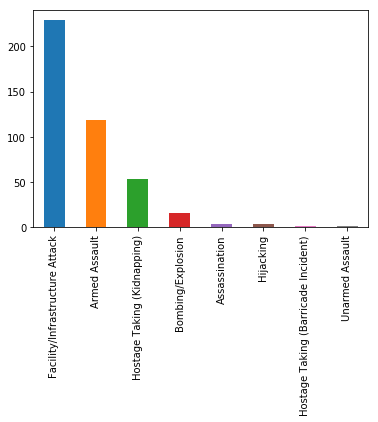

In [68]:
data.attacktype3_txt.value_counts().plot(kind="bar")

## Combined attacktypes

In [69]:
data.attacktype_txt.value_counts()

Bombing/Explosion                                                                     86079
Armed Assault                                                                         40927
Assassination                                                                         19190
Facility/Infrastructure Attack                                                        10168
Hostage Taking (Kidnapping)                                                            9423
Unknown                                                                                7276
Bombing/Explosion, Armed Assault                                                       1782
Hostage Taking (Kidnapping), Armed Assault                                             1217
Armed Assault, Facility/Infrastructure Attack                                          1048
Unarmed Assault                                                                         953
Hostage Taking (Barricade Incident)                                             

As attacktypes are categorical values, I am going to make two separate types of analysis to find correlations between data. The first on is a chi-squared test and it would be used to calculate differences in distribution of values between categorical values. The second one is ANOVA test and it is used to find correlation between numerical and categorical values.

### Chi-square test

https://en.wikipedia.org/wiki/Chi-squared_test

In [70]:
# Lists all categorical columns
cols = data.columns
num_cols = data._get_numeric_data().columns
cat_cols =  list(set(cols) - set(num_cols))
print(cat_cols)

['country_txt', 'related', 'motive', 'approxdate', 'weaptype2_txt', 'attacktype3_txt', 'gsubname2', 'target2', 'natlty2_txt', 'weapsubtype4_txt', 'gname2', 'provstate', 'hostkidoutcome_txt', 'weaptype1_txt', 'alternative_txt', 'weaptype3_txt', 'attacktype2_txt', 'targtype1_txt', 'gsubname3', 'claimmode3_txt', 'gsubname', 'targsubtype2_txt', 'claimmode_txt', 'propextent_txt', 'targtype3_txt', 'natlty1_txt', 'attacktype1_txt', 'targtype2_txt', 'region_txt', 'targsubtype1_txt', 'corp2', 'natlty3_txt', 'divert', 'corp3', 'target3', 'claimmode2_txt', 'target1', 'corp1', 'weapsubtype2_txt', 'weapsubtype1_txt', 'kidhijcountry', 'targsubtype3_txt', 'gname', 'city', 'gname3', 'weaptype4_txt', 'weapsubtype3_txt', 'attacktype_txt']


#### Before 1997

In [71]:
# Creates a dataset containing only categorical columns
data_for_analysis_old = data_old[cat_cols].copy(deep=True)
data_for_analysis_old.head()

,country_txt,related,motive,approxdate,weaptype2_txt,attacktype3_txt,gsubname2,target2,natlty2_txt,weapsubtype4_txt,...,weapsubtype2_txt,weapsubtype1_txt,kidhijcountry,targsubtype3_txt,gname,city,gname3,weaptype4_txt,weapsubtype3_txt,attacktype_txt
0,Dominican Republic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,MANO-D,Santo Domingo,NaN,NaN,NaN,Assassination
1,Mexico,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Mexico,NaN,23rd of September Communist League,Mexico City,NaN,NaN,NaN,Hostage Taking (Kidnapping)
2,Philippines,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Unknown,Unknown,NaN,NaN,NaN,Assassination
3,Greece,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Unknown Explosive Type,NaN,NaN,Unknown,Athens,NaN,NaN,NaN,Bombing/Explosion
4,Japan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Unknown,Fukouka,NaN,NaN,NaN,Facility/Infrastructure Attack


In [72]:
# Removes individual attacktype_txt columns
# del data_for_analysis_old["attacktype1_txt"]
del data_for_analysis_old["attacktype2_txt"]
del data_for_analysis_old["attacktype3_txt"]

In [73]:
# Finds all possible categorical column pairs
cols = data_for_analysis_old.columns
column_pairs = find_pairs(cols)
print(column_pairs)

[('country_txt', 'related'), ('country_txt', 'motive'), ('country_txt', 'approxdate'), ('country_txt', 'weaptype2_txt'), ('country_txt', 'gsubname2'), ('country_txt', 'target2'), ('country_txt', 'natlty2_txt'), ('country_txt', 'weapsubtype4_txt'), ('country_txt', 'gname2'), ('country_txt', 'provstate'), ('country_txt', 'hostkidoutcome_txt'), ('country_txt', 'weaptype1_txt'), ('country_txt', 'alternative_txt'), ('country_txt', 'weaptype3_txt'), ('country_txt', 'targtype1_txt'), ('country_txt', 'gsubname3'), ('country_txt', 'claimmode3_txt'), ('country_txt', 'gsubname'), ('country_txt', 'targsubtype2_txt'), ('country_txt', 'claimmode_txt'), ('country_txt', 'propextent_txt'), ('country_txt', 'targtype3_txt'), ('country_txt', 'natlty1_txt'), ('country_txt', 'attacktype1_txt'), ('country_txt', 'targtype2_txt'), ('country_txt', 'region_txt'), ('country_txt', 'targsubtype1_txt'), ('country_txt', 'corp2'), ('country_txt', 'natlty3_txt'), ('country_txt', 'divert'), ('country_txt', 'corp3'), ('c

In [74]:
calculate_chi_square_for_column(column_pairs, data_for_analysis_old, "attacktype1_txt", 0.45)

Total pairs:  2070
Current pair:  23 )  ('country_txt', 'attacktype1_txt')
Insufficient data for analysis
Current pair:  68 )  ('related', 'attacktype1_txt')
Insufficient data for analysis
Current pair:  113 )  ('motive', 'attacktype1_txt')
Insufficient data for analysis
Current pair:  158 )  ('approxdate', 'attacktype1_txt')
Insufficient data for analysis
Current pair:  203 )  ('weaptype2_txt', 'attacktype1_txt')
Insufficient data for analysis
Current pair:  248 )  ('gsubname2', 'attacktype1_txt')
Insufficient data for analysis
Current pair:  293 )  ('target2', 'attacktype1_txt')
Insufficient data for analysis
Current pair:  338 )  ('natlty2_txt', 'attacktype1_txt')
Insufficient data for analysis
Current pair:  383 )  ('weapsubtype4_txt', 'attacktype1_txt')
Insufficient data for analysis
Current pair:  428 )  ('gname2', 'attacktype1_txt')
Insufficient data for analysis
Current pair:  473 )  ('provstate', 'attacktype1_txt')
Insufficient data for analysis
Current pair:  518 )  ('hostkid

/home/achaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


Insufficient data for analysis
Current pair:  878 )  ('targsubtype2_txt', 'attacktype1_txt')
Insufficient data for analysis
Current pair:  923 )  ('claimmode_txt', 'attacktype1_txt')
Insufficient data for analysis
Current pair:  968 )  ('propextent_txt', 'attacktype1_txt')
Insufficient data for analysis
Current pair:  1013 )  ('targtype3_txt', 'attacktype1_txt')
Insufficient data for analysis
Current pair:  1058 )  ('natlty1_txt', 'attacktype1_txt')
Insufficient data for analysis
Current pair:  1080 )  ('attacktype1_txt', 'country_txt')
Insufficient data for analysis
Current pair:  1081 )  ('attacktype1_txt', 'related')
Insufficient data for analysis
Current pair:  1082 )  ('attacktype1_txt', 'motive')
Insufficient data for analysis
Current pair:  1083 )  ('attacktype1_txt', 'approxdate')
Insufficient data for analysis
Current pair:  1084 )  ('attacktype1_txt', 'weaptype2_txt')
Insufficient data for analysis
Current pair:  1085 )  ('attacktype1_txt', 'gsubname2')
Insufficient data for 

Insufficient data for analysis
Current pair:  1149 )  ('targtype2_txt', 'attacktype1_txt')
Insufficient data for analysis
Current pair:  1194 )  ('region_txt', 'attacktype1_txt')

attacktype1_txt              Armed Assault  Assassination  Bombing/Explosion  \
region_txt                                                                     
Central America & Caribbean           4289           1207               3182   
Middle East & North Africa            1806           1964               3472   
North America                          262            190               1353   
South America                         3228           2458               7466   
South Asia                            2071           1694               2081   
Sub-Saharan Africa                     986            721               1640   
Western Europe                        1250           2841               6331   

attacktype1_txt              Facility/Infrastructure Attack  Hijacking  \
region_txt               

In [127]:
# Controlls one pair that showed results
calculate_chi_square_for_column([("claimmode3_txt", "attacktype_txt")], data_for_analysis_old, "attacktype_txt", 0.45)

Total pairs:  1
Current pair:  0 )  ('claimmode3_txt', 'attacktype_txt')

attacktype_txt  Bombing/Explosion
claimmode3_txt                   
Other                           7
(0.0, 1.0, 0, array([[7.]]))



The only pair that gave the results consists of empty table and therefore the result is false. The conducted test shows that **there is no dependance between categorical values in the data before the year 1997**. One of the possible reasons lies in fact, that many statistics were collected only from year 1997.

#### After 1997

In [76]:
# Creates a dataset containing only categorical columns
data_for_analysis_new = data_new[cat_cols].copy(deep=True)
data_for_analysis_new.head()

,country_txt,related,motive,approxdate,weaptype2_txt,attacktype3_txt,gsubname2,target2,natlty2_txt,weapsubtype4_txt,...,weapsubtype2_txt,weapsubtype1_txt,kidhijcountry,targsubtype3_txt,gname,city,gname3,weaptype4_txt,weapsubtype3_txt,attacktype_txt
64310,Nepal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Unknown Gun Type,NaN,NaN,Unknown,Bethan,NaN,NaN,NaN,Armed Assault
64311,West Bank and Gaza Strip,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Automatic or Semi-Automatic Rifle,NaN,NaN,Jewish Extremists,Hebron,NaN,NaN,NaN,Armed Assault
64312,United States,"199701010003, 199701010004, 199701010005",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Anti-Abortion extremists,Tulsa,NaN,NaN,NaN,Facility/Infrastructure Attack
64313,United States,"199701010004, 199701010003, 199701010005",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Anti-Abortion extremists,Tulsa,NaN,NaN,NaN,Facility/Infrastructure Attack
64314,United States,"199701010005, 199701010003, 199701010004",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Anti-Abortion extremists,Tulsa,NaN,NaN,NaN,Facility/Infrastructure Attack


In [77]:
# Removes individual attacktype_txt columns
#del data_for_analysis_new["attacktype1_txt"]
del data_for_analysis_new["attacktype2_txt"]
del data_for_analysis_new["attacktype3_txt"]

In [78]:
# Finds all possible categorical column pairs
cols = data_for_analysis_new.columns
column_pairs = find_pairs(cols)
print(column_pairs)

[('country_txt', 'related'), ('country_txt', 'motive'), ('country_txt', 'approxdate'), ('country_txt', 'weaptype2_txt'), ('country_txt', 'gsubname2'), ('country_txt', 'target2'), ('country_txt', 'natlty2_txt'), ('country_txt', 'weapsubtype4_txt'), ('country_txt', 'gname2'), ('country_txt', 'provstate'), ('country_txt', 'hostkidoutcome_txt'), ('country_txt', 'weaptype1_txt'), ('country_txt', 'alternative_txt'), ('country_txt', 'weaptype3_txt'), ('country_txt', 'targtype1_txt'), ('country_txt', 'gsubname3'), ('country_txt', 'claimmode3_txt'), ('country_txt', 'gsubname'), ('country_txt', 'targsubtype2_txt'), ('country_txt', 'claimmode_txt'), ('country_txt', 'propextent_txt'), ('country_txt', 'targtype3_txt'), ('country_txt', 'natlty1_txt'), ('country_txt', 'attacktype1_txt'), ('country_txt', 'targtype2_txt'), ('country_txt', 'region_txt'), ('country_txt', 'targsubtype1_txt'), ('country_txt', 'corp2'), ('country_txt', 'natlty3_txt'), ('country_txt', 'divert'), ('country_txt', 'corp3'), ('c

In [79]:
calculate_chi_square_for_column(column_pairs, data_for_analysis_new, "attacktype1_txt", 0.6)

Total pairs:  2070
Current pair:  23 )  ('country_txt', 'attacktype1_txt')
Insufficient data for analysis
Current pair:  68 )  ('related', 'attacktype1_txt')
Insufficient data for analysis
Current pair:  113 )  ('motive', 'attacktype1_txt')
Insufficient data for analysis
Current pair:  158 )  ('approxdate', 'attacktype1_txt')
Insufficient data for analysis
Current pair:  203 )  ('weaptype2_txt', 'attacktype1_txt')
Insufficient data for analysis
Current pair:  248 )  ('gsubname2', 'attacktype1_txt')
Insufficient data for analysis
Current pair:  293 )  ('target2', 'attacktype1_txt')
Insufficient data for analysis
Current pair:  338 )  ('natlty2_txt', 'attacktype1_txt')
Insufficient data for analysis
Current pair:  383 )  ('weapsubtype4_txt', 'attacktype1_txt')
Insufficient data for analysis
Current pair:  428 )  ('gname2', 'attacktype1_txt')
Insufficient data for analysis
Current pair:  473 )  ('provstate', 'attacktype1_txt')
Insufficient data for analysis
Current pair:  518 )  ('hostkid

Insufficient data for analysis
Current pair:  1120 )  ('attacktype1_txt', 'city')
Insufficient data for analysis
Current pair:  1121 )  ('attacktype1_txt', 'gname3')
Insufficient data for analysis
Current pair:  1122 )  ('attacktype1_txt', 'weaptype4_txt')
Insufficient data for analysis
Current pair:  1123 )  ('attacktype1_txt', 'weapsubtype3_txt')
Insufficient data for analysis
Current pair:  1124 )  ('attacktype1_txt', 'attacktype_txt')
Insufficient data for analysis
Current pair:  1149 )  ('targtype2_txt', 'attacktype1_txt')
Insufficient data for analysis
Current pair:  1194 )  ('region_txt', 'attacktype1_txt')

attacktype1_txt             Armed Assault  Assassination  Bombing/Explosion  \
region_txt                                                                    
Eastern Europe                       1170            285               2432   
Middle East & North Africa           7467           2242              27436   
North America                         186             65     

Found no correlation whith the treshold 60%. 

In [75]:
calculate_chi_square_for_column(column_pairs, data_for_analysis_new, "attacktype1_txt", 0.45)

NameError: name 'data_for_analysis_new' is not defined

Found no correlation with the treshold 45%. As a result, **there is no correlation between attacktype_txt and tcategorical columns**. Further analysis should be conducted to find correaltion between "attacktype_txt" and numerical columns. Such analysis requires ANOVA test.

### ANOVA test

#### Before year 1997

In [80]:
# Lists all cnumerical columns
cols = data.columns
num_cols = data._get_numeric_data().columns
#num_cols.append("attacktype_txt")
print(type(num_cols))

<class 'pandas.core.indexes.base.Index'>


In [84]:
# Creates a dataset containing only categorical columns
data_for_analysis_old = data_old[num_cols].copy(deep=True)
data_for_analysis_old = data_for_analysis_old.assign(attacktype1_txt=data_old["attacktype1_txt"].values)
del data_for_analysis_old["Unnamed: 0"]
del data_for_analysis_old["eventid"]
data_for_analysis_old.head()

,iyear,imonth,iday,extended,latitude,longitude,specificity,vicinity,crit1,crit2,...,nhostkidus,nhours,ndays,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,nreleased,attacktype1_txt
0,1970,7,2,0,18.456792,-69.951164,1.0,0.0,1,1,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Assassination
1,1970,0,0,0,19.371887,-99.086624,1.0,0.0,1,1,...,0.0,NaN,NaN,1.0,800000.0,NaN,NaN,NaN,NaN,Hostage Taking (Kidnapping)
2,1970,1,0,0,15.478598,120.599741,4.0,0.0,1,1,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Assassination
3,1970,1,0,0,37.997490,23.762728,1.0,0.0,1,1,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Bombing/Explosion
4,1970,1,0,0,33.580412,130.396361,1.0,0.0,1,1,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Facility/Infrastructure Attack


In [85]:
# Finds all possible column pairs
cols = data_for_analysis_old.columns
column_pairs = find_pairs(cols)
print(column_pairs)

[('iyear', 'imonth'), ('iyear', 'iday'), ('iyear', 'extended'), ('iyear', 'latitude'), ('iyear', 'longitude'), ('iyear', 'specificity'), ('iyear', 'vicinity'), ('iyear', 'crit1'), ('iyear', 'crit2'), ('iyear', 'crit3'), ('iyear', 'doubtterr'), ('iyear', 'multiple'), ('iyear', 'success'), ('iyear', 'suicide'), ('iyear', 'guncertain1'), ('iyear', 'guncertain2'), ('iyear', 'guncertain3'), ('iyear', 'individual'), ('iyear', 'nperps'), ('iyear', 'nperpcap'), ('iyear', 'claimed'), ('iyear', 'claim2'), ('iyear', 'claim3'), ('iyear', 'compclaim'), ('iyear', 'nkill'), ('iyear', 'nkillus'), ('iyear', 'nkillter'), ('iyear', 'nwound'), ('iyear', 'nwoundus'), ('iyear', 'nwoundte'), ('iyear', 'property'), ('iyear', 'propvalue'), ('iyear', 'ishostkid'), ('iyear', 'nhostkid'), ('iyear', 'nhostkidus'), ('iyear', 'nhours'), ('iyear', 'ndays'), ('iyear', 'ransom'), ('iyear', 'ransomamt'), ('iyear', 'ransomamtus'), ('iyear', 'ransompaid'), ('iyear', 'ransompaidus'), ('iyear', 'nreleased'), ('iyear', 'atta

In [86]:
perform_anova_for_column(possible_pairs=column_pairs, data=data_for_analysis_old, column="attacktype1_txt", treshold=0.6)

Total pairs:  1980
Current pair:  43 )  ('iyear', 'attacktype1_txt')

                            OLS Regression Results                            
Dep. Variable:                  iyear   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     110.9
Date:                Mon, 17 Dec 2018   Prob (F-statistic):          6.77e-185
Time:                        11:47:27   Log-Likelihood:            -2.0845e+05
No. Observations:               64310   AIC:                         4.169e+05
Df Residuals:                   64301   BIC:                         4.170e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------

                            OLS Regression Results                            
Dep. Variable:                  crit2   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     60.84
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           1.21e-99
Time:                        11:47:31   Log-Likelihood:                 55664.
No. Observations:               64310   AIC:                        -1.113e+05
Df Residuals:                   64301   BIC:                        -1.112e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

Could not calculate ANOVA results

Current pair:  1962 )  ('attacktype1_txt', 'nkillus')
Insufficient data for analysis
Current pair:  1963 )  ('attacktype1_txt', 'nkillter')
Insufficient data for analysis
Current pair:  1964 )  ('attacktype1_txt', 'nwound')

Could not calculate ANOVA results

Current pair:  1965 )  ('attacktype1_txt', 'nwoundus')
Insufficient data for analysis
Current pair:  1966 )  ('attacktype1_txt', 'nwoundte')
Insufficient data for analysis
Current pair:  1967 )  ('attacktype1_txt', 'property')

Could not calculate ANOVA results

Current pair:  1968 )  ('attacktype1_txt', 'propvalue')
Insufficient data for analysis
Current pair:  1969 )  ('attacktype1_txt', 'ishostkid')

Could not calculate ANOVA results

Current pair:  1970 )  ('attacktype1_txt', 'nhostkid')
Insufficient data for analysis
Current pair:  1971 )  ('attacktype1_txt', 'nhostkidus')
Insufficient data for analysis
Current pair:  1972 )  ('attacktype1_txt', 'nhours')
Insufficient data for analysis
Curre

The ANOVA test shows that there is some correlation between specificity and attacktype. Further inspection shows that specificity is a categorical value and should have been converted to that. ANOVA test results are invalid for this column.

The ANOVA test showed strong correlation between crit1 and attacktype_txt. The reason for that could lie in fact that the most popular attacktype is explosion which constitutes to more than half of the incidents. And most incidents fulfill crit1 so this test result is not invalid per se but does not show much.

#### After 1997

In [19]:
# Lists all cnumerical columns
cols = data.columns
num_cols = data._get_numeric_data().columns
#num_cols.append("attacktype_txt")
print(type(num_cols))

<class 'pandas.core.indexes.base.Index'>


In [20]:
# Creates a dataset containing only categorical columns
data_for_analysis_new = data_new[num_cols].copy(deep=True)
data_for_analysis_new = data_for_analysis_new.assign(attacktype1_txt=data_new["attacktype1_txt"].values)
del data_for_analysis_new["Unnamed: 0"]
#del data_for_analysis_new["eventid"]
data_for_analysis_new.head()

,eventid,iyear,imonth,iday,extended,latitude,longitude,specificity,vicinity,crit1,...,nhostkidus,nhours,ndays,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,nreleased,attacktype1_txt
64310,199701010001,1997,1,1,0,27.493003,85.824033,1.0,1.0,1,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Armed Assault
64311,199701010002,1997,1,1,0,31.530243,35.094162,1.0,0.0,1,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Armed Assault
64312,199701010003,1997,1,1,0,36.149745,-95.993334,1.0,0.0,1,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Facility/Infrastructure Attack
64313,199701010004,1997,1,1,0,36.149745,-95.993334,1.0,0.0,1,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Facility/Infrastructure Attack
64314,199701010005,1997,1,1,0,36.149745,-95.993334,1.0,0.0,1,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Facility/Infrastructure Attack


In [21]:
# Finds all possible column pairs
cols = data_for_analysis_new.columns
column_pairs = find_pairs(cols)
print(column_pairs)

[('eventid', 'iyear'), ('eventid', 'imonth'), ('eventid', 'iday'), ('eventid', 'extended'), ('eventid', 'latitude'), ('eventid', 'longitude'), ('eventid', 'specificity'), ('eventid', 'vicinity'), ('eventid', 'crit1'), ('eventid', 'crit2'), ('eventid', 'crit3'), ('eventid', 'doubtterr'), ('eventid', 'multiple'), ('eventid', 'success'), ('eventid', 'suicide'), ('eventid', 'guncertain1'), ('eventid', 'guncertain2'), ('eventid', 'guncertain3'), ('eventid', 'individual'), ('eventid', 'nperps'), ('eventid', 'nperpcap'), ('eventid', 'claimed'), ('eventid', 'claim2'), ('eventid', 'claim3'), ('eventid', 'compclaim'), ('eventid', 'nkill'), ('eventid', 'nkillus'), ('eventid', 'nkillter'), ('eventid', 'nwound'), ('eventid', 'nwoundus'), ('eventid', 'nwoundte'), ('eventid', 'property'), ('eventid', 'propvalue'), ('eventid', 'ishostkid'), ('eventid', 'nhostkid'), ('eventid', 'nhostkidus'), ('eventid', 'nhours'), ('eventid', 'ndays'), ('eventid', 'ransom'), ('eventid', 'ransomamt'), ('eventid', 'rans

In [90]:
perform_anova_for_column(possible_pairs=column_pairs, data=data_for_analysis_new, column="attacktype1_txt", treshold=0.6)

Total pairs:  2070
Current pair:  44 )  ('eventid', 'attacktype1_txt')

                            OLS Regression Results                            
Dep. Variable:                eventid   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     59.49
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           1.67e-97
Time:                        11:49:05   Log-Likelihood:            -2.5197e+06
No. Observations:              117381   AIC:                         5.039e+06
Df Residuals:                  117372   BIC:                         5.039e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------

The F-statistic and p-value are too low

Current pair:  404 )  ('vicinity', 'attacktype1_txt')

The F-statistic and p-value are too low

Current pair:  449 )  ('crit1', 'attacktype1_txt')

                            OLS Regression Results                            
Dep. Variable:                  crit1   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     84.10
Date:                Mon, 17 Dec 2018   Prob (F-statistic):          1.30e-139
Time:                        11:49:10   Log-Likelihood:                 98854.
No. Observations:              117381   AIC:                        -1.977e+05
Df Residuals:                  117372   BIC:                        -1.976e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     

The F-statistic and p-value are too low

Current pair:  1034 )  ('claimed', 'attacktype1_txt')

The F-statistic and p-value are too low

Current pair:  1079 )  ('claim2', 'attacktype1_txt')
Insufficient data for analysis
Current pair:  1124 )  ('claim3', 'attacktype1_txt')
Insufficient data for analysis
Current pair:  1169 )  ('compclaim', 'attacktype1_txt')
Insufficient data for analysis
Current pair:  1214 )  ('nkill', 'attacktype1_txt')

                            OLS Regression Results                            
Dep. Variable:                  nkill   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     122.9
Date:                Mon, 17 Dec 2018   Prob (F-statistic):          4.40e-206
Time:                        11:49:17   Log-Likelihood:            -4.4438e+05
No. Observations:              113034   AIC:                         8.888e+05
Df

                            OLS Regression Results                            
Dep. Variable:                 nwound   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     96.84
Date:                Mon, 17 Dec 2018   Prob (F-statistic):          2.21e-161
Time:                        11:49:19   Log-Likelihood:            -5.5607e+05
No. Observations:              108968   AIC:                         1.112e+06
Df Residuals:                  108959   BIC:                         1.112e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

Could not calculate ANOVA results

Current pair:  2038 )  ('attacktype1_txt', 'multiple')

Could not calculate ANOVA results

Current pair:  2039 )  ('attacktype1_txt', 'success')

Could not calculate ANOVA results

Current pair:  2040 )  ('attacktype1_txt', 'suicide')

Could not calculate ANOVA results

Current pair:  2041 )  ('attacktype1_txt', 'guncertain1')

Could not calculate ANOVA results

Current pair:  2042 )  ('attacktype1_txt', 'guncertain2')
Insufficient data for analysis
Current pair:  2043 )  ('attacktype1_txt', 'guncertain3')
Insufficient data for analysis
Current pair:  2044 )  ('attacktype1_txt', 'individual')

Could not calculate ANOVA results

Current pair:  2045 )  ('attacktype1_txt', 'nperps')
Insufficient data for analysis
Current pair:  2046 )  ('attacktype1_txt', 'nperpcap')

Could not calculate ANOVA results

Current pair:  2047 )  ('attacktype1_txt', 'claimed')

Could not calculate ANOVA results

Current pair:  2048 )  ('attacktype1_txt', 'claim2')
Insufficien

In [99]:
test = multi.MultiComparison(data_for_analysis_new["longitude"], data_for_analysis_new["attacktype1_txt"])
res = test.tukeyhsd()
print(res.summary())

                         Multiple Comparison of Means - Tukey HSD,FWER=0.05                        
               group1                              group2               meandiff lower upper reject
---------------------------------------------------------------------------------------------------
           Armed Assault                       Assassination              nan     nan   nan  False 
           Armed Assault                     Bombing/Explosion            nan     nan   nan  False 
           Armed Assault               Facility/Infrastructure Attack     nan     nan   nan  False 
           Armed Assault                         Hijacking                nan     nan   nan  False 
           Armed Assault            Hostage Taking (Barricade Incident)   nan     nan   nan  False 
           Armed Assault                Hostage Taking (Kidnapping)       nan     nan   nan  False 
           Armed Assault                      Unarmed Assault             nan     nan   nan  False 


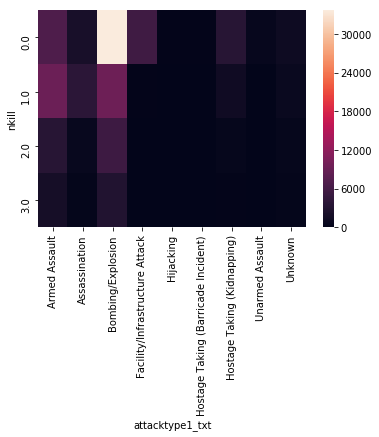

In [44]:
presentation = pd.crosstab(data_for_analysis_new.nkill, data_for_analysis_new.attacktype1_txt)
presentation = remove_infrequent_rows(presentation, 0.0)
sns.heatmap(presentation)
plt.savefig("random.png")

In [41]:
presentation

attacktype1_txt,Armed Assault,Assassination,Bombing/Explosion,Facility/Infrastructure Attack,Hijacking,Hostage Taking (Barricade Incident),Hostage Taking (Kidnapping),Unarmed Assault,Unknown
nkill,,,,,,,,,
0.0,6883,2124,33703,5544,227,198,3441,547,1230
1.0,9329,3838,9458,141,29,25,1430,85,814
2.0,3472,709,5432,49,12,10,457,21,460
3.0,1856,284,2988,35,6,14,239,9,359


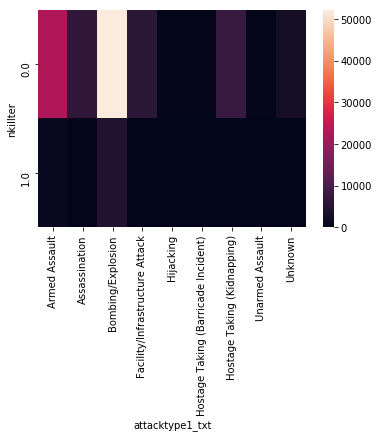

In [30]:
presentation = pd.crosstab(data_for_analysis_new.nkillter, data_for_analysis_new.attacktype1_txt)
presentation = remove_infrequent_rows(presentation, 0.0)
sns.heatmap(presentation)

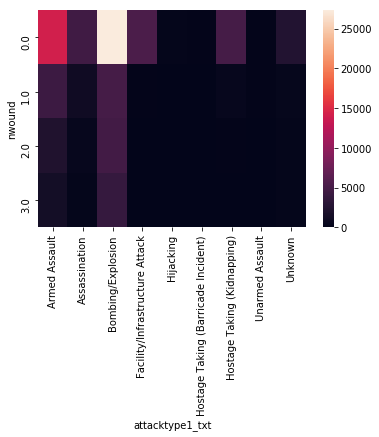

In [34]:
presentation = pd.crosstab(data_for_analysis_new.nwound, data_for_analysis_new.attacktype1_txt)
presentation = remove_infrequent_rows(presentation, 0.0)
sns.heatmap(presentation)

Could not find any correlation between attacktype and other values. Some of the calculations failes probably due to some workings of python which I fully do not understand. One possibility lies in fact that the data is not normally distributed which affects calculations.

# Identifying important correlations for the target nationalities

In [57]:
data = pd.read_csv("final_data.csv")

/home/achaad/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (5,24,25,44,45,46,57,59,67,68,83,84) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [58]:
data.natlty1_txt.describe()

count     180132
unique       215
top         Iraq
freq       24113
Name: natlty1_txt, dtype: object

In [59]:
data.natlty1_txt.value_counts()

Iraq                                  24113
Pakistan                              13900
India                                 12098
Afghanistan                           10931
Colombia                               7922
Philippines                            6685
Peru                                   5840
El Salvador                            5212
United States                          5065
Turkey                                 4636
Israel                                 4097
Thailand                               3804
Nigeria                                3759
Northern Ireland                       3367
Somalia                                3160
Yemen                                  3123
Spain                                  3096
France                                 2918
Sri Lanka                              2851
International                          2699
Algeria                                2664
Egypt                                  2523
Russia                          

## Chi-square test

### Before 1997

In [63]:
# Lists all categorical columns
cols = data.columns
num_cols = data._get_numeric_data().columns
cat_cols =  list(set(cols) - set(num_cols))
print(cat_cols)

['corp3', 'provstate', 'hostkidoutcome_txt', 'gname3', 'corp2', 'attacktype3_txt', 'city', 'weapsubtype1_txt', 'gname', 'kidhijcountry', 'weaptype1_txt', 'corp1', 'weapsubtype2_txt', 'targtype1_txt', 'propextent_txt', 'weaptype3_txt', 'region_txt', 'related', 'claimmode3_txt', 'attacktype2_txt', 'weaptype2_txt', 'approxdate', 'targtype3_txt', 'natlty2_txt', 'gsubname2', 'natlty1_txt', 'weapsubtype4_txt', 'natlty3_txt', 'claimmode_txt', 'gname2', 'weapsubtype3_txt', 'targtype2_txt', 'country_txt', 'target1', 'motive', 'alternative_txt', 'gsubname3', 'targsubtype3_txt', 'gsubname', 'attacktype1_txt', 'weaptype4_txt', 'targsubtype2_txt', 'target3', 'targsubtype1_txt', 'claimmode2_txt', 'target2', 'divert']


In [71]:
# Creates a dataset containing only categorical columns
data_for_analysis_old = data_old[cat_cols].copy(deep=True)
data_for_analysis_old.head()

,corp3,provstate,hostkidoutcome_txt,gname3,corp2,attacktype3_txt,city,weapsubtype1_txt,gname,kidhijcountry,...,targsubtype3_txt,gsubname,attacktype1_txt,weaptype4_txt,targsubtype2_txt,target3,targsubtype1_txt,claimmode2_txt,target2,divert
0,NaN,NaN,NaN,NaN,NaN,NaN,Santo Domingo,NaN,MANO-D,NaN,...,NaN,NaN,Assassination,NaN,NaN,NaN,Named Civilian,NaN,NaN,NaN
1,NaN,Federal,NaN,NaN,NaN,NaN,Mexico City,NaN,23rd of September Communist League,Mexico,...,NaN,NaN,Hostage Taking (Kidnapping),NaN,NaN,NaN,"Diplomatic Personnel (outside of embassy, cons...",NaN,NaN,NaN
2,NaN,Tarlac,NaN,NaN,NaN,NaN,Unknown,NaN,Unknown,NaN,...,NaN,NaN,Assassination,NaN,NaN,NaN,Radio Journalist/Staff/Facility,NaN,NaN,NaN
3,NaN,Attica,NaN,NaN,NaN,NaN,Athens,Unknown Explosive Type,Unknown,NaN,...,NaN,NaN,Bombing/Explosion,NaN,NaN,NaN,Embassy/Consulate,NaN,NaN,NaN
4,NaN,Fukouka,NaN,NaN,NaN,NaN,Fukouka,NaN,Unknown,NaN,...,NaN,NaN,Facility/Infrastructure Attack,NaN,NaN,NaN,Embassy/Consulate,NaN,NaN,NaN


In [72]:
# Finds all possible column pairs
cols = data_for_analysis_old.columns
column_pairs = find_pairs(cols)
print(column_pairs)

[('corp3', 'provstate'), ('corp3', 'hostkidoutcome_txt'), ('corp3', 'gname3'), ('corp3', 'corp2'), ('corp3', 'attacktype3_txt'), ('corp3', 'city'), ('corp3', 'weapsubtype1_txt'), ('corp3', 'gname'), ('corp3', 'kidhijcountry'), ('corp3', 'weaptype1_txt'), ('corp3', 'corp1'), ('corp3', 'weapsubtype2_txt'), ('corp3', 'targtype1_txt'), ('corp3', 'propextent_txt'), ('corp3', 'weaptype3_txt'), ('corp3', 'region_txt'), ('corp3', 'related'), ('corp3', 'claimmode3_txt'), ('corp3', 'attacktype2_txt'), ('corp3', 'weaptype2_txt'), ('corp3', 'approxdate'), ('corp3', 'targtype3_txt'), ('corp3', 'natlty2_txt'), ('corp3', 'gsubname2'), ('corp3', 'natlty1_txt'), ('corp3', 'weapsubtype4_txt'), ('corp3', 'natlty3_txt'), ('corp3', 'claimmode_txt'), ('corp3', 'gname2'), ('corp3', 'weapsubtype3_txt'), ('corp3', 'targtype2_txt'), ('corp3', 'country_txt'), ('corp3', 'target1'), ('corp3', 'motive'), ('corp3', 'alternative_txt'), ('corp3', 'gsubname3'), ('corp3', 'targsubtype3_txt'), ('corp3', 'gsubname'), ('co

In [76]:
calculate_chi_square_for_column(column_pairs, data_for_analysis_old, "natlty1_txt", 0.45)

Total pairs:  2162
Current pair:  24 )  ('corp3', 'natlty1_txt')
Insufficient data for analysis
Current pair:  70 )  ('provstate', 'natlty1_txt')
Insufficient data for analysis
Current pair:  116 )  ('hostkidoutcome_txt', 'natlty1_txt')
Insufficient data for analysis
Current pair:  162 )  ('gname3', 'natlty1_txt')
Insufficient data for analysis
Current pair:  208 )  ('corp2', 'natlty1_txt')
Insufficient data for analysis
Current pair:  254 )  ('attacktype3_txt', 'natlty1_txt')
Insufficient data for analysis
Current pair:  300 )  ('city', 'natlty1_txt')
Insufficient data for analysis
Current pair:  346 )  ('weapsubtype1_txt', 'natlty1_txt')
Insufficient data for analysis
Current pair:  392 )  ('gname', 'natlty1_txt')
Insufficient data for analysis
Current pair:  438 )  ('kidhijcountry', 'natlty1_txt')
Insufficient data for analysis
Current pair:  484 )  ('weaptype1_txt', 'natlty1_txt')
Insufficient data for analysis
Current pair:  530 )  ('corp1', 'natlty1_txt')
Insufficient data for an

/home/achaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


Insufficient data for analysis
Current pair:  1188 )  ('natlty1_txt', 'attacktype1_txt')
Insufficient data for analysis
Current pair:  1189 )  ('natlty1_txt', 'weaptype4_txt')
Insufficient data for analysis
Current pair:  1190 )  ('natlty1_txt', 'targsubtype2_txt')
Insufficient data for analysis
Current pair:  1191 )  ('natlty1_txt', 'target3')
Insufficient data for analysis
Current pair:  1192 )  ('natlty1_txt', 'targsubtype1_txt')
Insufficient data for analysis
Current pair:  1193 )  ('natlty1_txt', 'claimmode2_txt')
Insufficient data for analysis
Current pair:  1194 )  ('natlty1_txt', 'target2')
Insufficient data for analysis
Current pair:  1195 )  ('natlty1_txt', 'divert')
Insufficient data for analysis
Current pair:  1221 )  ('weapsubtype4_txt', 'natlty1_txt')
Insufficient data for analysis
Current pair:  1267 )  ('natlty3_txt', 'natlty1_txt')
Insufficient data for analysis
Current pair:  1313 )  ('claimmode_txt', 'natlty1_txt')
Insufficient data for analysis
Current pair:  1359 )

Found no correlation

### After 1997

In [77]:
# Creates a dataset containing only categorical columns
data_for_analysis_new = data_new[cat_cols].copy(deep=True)
data_for_analysis_new.head()

,corp3,provstate,hostkidoutcome_txt,gname3,corp2,attacktype3_txt,city,weapsubtype1_txt,gname,kidhijcountry,...,targsubtype3_txt,gsubname,attacktype1_txt,weaptype4_txt,targsubtype2_txt,target3,targsubtype1_txt,claimmode2_txt,target2,divert
64310,NaN,Central,NaN,NaN,NaN,NaN,Bethan,Unknown Gun Type,Unknown,NaN,...,NaN,NaN,Armed Assault,NaN,NaN,NaN,"Police Building (headquarters, station, school)",NaN,NaN,NaN
64311,NaN,West Bank,NaN,NaN,NaN,NaN,Hebron,Automatic or Semi-Automatic Rifle,Jewish Extremists,NaN,...,NaN,Settlers,Armed Assault,NaN,NaN,NaN,Marketplace/Plaza/Square,NaN,NaN,NaN
64312,NaN,Oklahoma,NaN,NaN,NaN,NaN,Tulsa,NaN,Anti-Abortion extremists,NaN,...,NaN,NaN,Facility/Infrastructure Attack,NaN,NaN,NaN,Clinics,NaN,NaN,NaN
64313,NaN,Oklahoma,NaN,NaN,NaN,NaN,Tulsa,NaN,Anti-Abortion extremists,NaN,...,NaN,NaN,Facility/Infrastructure Attack,NaN,NaN,NaN,Clinics,NaN,NaN,NaN
64314,NaN,Oklahoma,NaN,NaN,NaN,NaN,Tulsa,NaN,Anti-Abortion extremists,NaN,...,NaN,NaN,Facility/Infrastructure Attack,NaN,NaN,NaN,Clinics,NaN,NaN,NaN


In [78]:
# Finds all possible column pairs
cols = data_for_analysis_new.columns
column_pairs = find_pairs(cols)
print(column_pairs)

[('corp3', 'provstate'), ('corp3', 'hostkidoutcome_txt'), ('corp3', 'gname3'), ('corp3', 'corp2'), ('corp3', 'attacktype3_txt'), ('corp3', 'city'), ('corp3', 'weapsubtype1_txt'), ('corp3', 'gname'), ('corp3', 'kidhijcountry'), ('corp3', 'weaptype1_txt'), ('corp3', 'corp1'), ('corp3', 'weapsubtype2_txt'), ('corp3', 'targtype1_txt'), ('corp3', 'propextent_txt'), ('corp3', 'weaptype3_txt'), ('corp3', 'region_txt'), ('corp3', 'related'), ('corp3', 'claimmode3_txt'), ('corp3', 'attacktype2_txt'), ('corp3', 'weaptype2_txt'), ('corp3', 'approxdate'), ('corp3', 'targtype3_txt'), ('corp3', 'natlty2_txt'), ('corp3', 'gsubname2'), ('corp3', 'natlty1_txt'), ('corp3', 'weapsubtype4_txt'), ('corp3', 'natlty3_txt'), ('corp3', 'claimmode_txt'), ('corp3', 'gname2'), ('corp3', 'weapsubtype3_txt'), ('corp3', 'targtype2_txt'), ('corp3', 'country_txt'), ('corp3', 'target1'), ('corp3', 'motive'), ('corp3', 'alternative_txt'), ('corp3', 'gsubname3'), ('corp3', 'targsubtype3_txt'), ('corp3', 'gsubname'), ('co

In [79]:
calculate_chi_square_for_column(column_pairs, data_for_analysis_new, "natlty1_txt", 0.45)

Total pairs:  2162
Current pair:  24 )  ('corp3', 'natlty1_txt')
Insufficient data for analysis
Current pair:  70 )  ('provstate', 'natlty1_txt')
Insufficient data for analysis
Current pair:  116 )  ('hostkidoutcome_txt', 'natlty1_txt')
Insufficient data for analysis
Current pair:  162 )  ('gname3', 'natlty1_txt')
Insufficient data for analysis
Current pair:  208 )  ('corp2', 'natlty1_txt')
Insufficient data for analysis
Current pair:  254 )  ('attacktype3_txt', 'natlty1_txt')
Insufficient data for analysis
Current pair:  300 )  ('city', 'natlty1_txt')
Insufficient data for analysis
Current pair:  346 )  ('weapsubtype1_txt', 'natlty1_txt')
Insufficient data for analysis
Current pair:  392 )  ('gname', 'natlty1_txt')
Insufficient data for analysis
Current pair:  438 )  ('kidhijcountry', 'natlty1_txt')
Insufficient data for analysis
Current pair:  484 )  ('weaptype1_txt', 'natlty1_txt')
Insufficient data for analysis
Current pair:  530 )  ('corp1', 'natlty1_txt')
Insufficient data for an

## Anova

### Before 1997

In [80]:
# Lists all cnumerical columns
cols = data.columns
num_cols = data._get_numeric_data().columns
#num_cols.append("attacktype_txt")
print(type(num_cols))

<class 'pandas.core.indexes.base.Index'>


In [82]:
# Creates a dataset containing only categorical columns
data_for_analysis_old = data_old[num_cols].copy(deep=True)
data_for_analysis_old = data_for_analysis_old.assign(natlty1_txt=data_old["natlty1_txt"].values)
del data_for_analysis_old["Unnamed: 0"]
del data_for_analysis_old["eventid"]
data_for_analysis_old.head()

,iyear,imonth,iday,extended,latitude,longitude,specificity,vicinity,crit1,crit2,...,nhostkidus,nhours,ndays,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,nreleased,natlty1_txt
0,1970,7,2,0,18.456792,-69.951164,1.0,0.0,1,1,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Dominican Republic
1,1970,0,0,0,19.371887,-99.086624,1.0,0.0,1,1,...,0.0,NaN,NaN,1.0,800000.0,NaN,NaN,NaN,NaN,Belgium
2,1970,1,0,0,15.478598,120.599741,4.0,0.0,1,1,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,United States
3,1970,1,0,0,37.997490,23.762728,1.0,0.0,1,1,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,United States
4,1970,1,0,0,33.580412,130.396361,1.0,0.0,1,1,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,United States


In [83]:
# Finds all possible column pairs
cols = data_for_analysis_old.columns
column_pairs = find_pairs(cols)
print(column_pairs)

[('iyear', 'imonth'), ('iyear', 'iday'), ('iyear', 'extended'), ('iyear', 'latitude'), ('iyear', 'longitude'), ('iyear', 'specificity'), ('iyear', 'vicinity'), ('iyear', 'crit1'), ('iyear', 'crit2'), ('iyear', 'crit3'), ('iyear', 'doubtterr'), ('iyear', 'multiple'), ('iyear', 'success'), ('iyear', 'suicide'), ('iyear', 'guncertain1'), ('iyear', 'guncertain2'), ('iyear', 'guncertain3'), ('iyear', 'individual'), ('iyear', 'nperps'), ('iyear', 'nperpcap'), ('iyear', 'claimed'), ('iyear', 'claim2'), ('iyear', 'claim3'), ('iyear', 'compclaim'), ('iyear', 'nkill'), ('iyear', 'nkillus'), ('iyear', 'nkillter'), ('iyear', 'nwound'), ('iyear', 'nwoundus'), ('iyear', 'nwoundte'), ('iyear', 'property'), ('iyear', 'propvalue'), ('iyear', 'ishostkid'), ('iyear', 'nhostkid'), ('iyear', 'nhostkidus'), ('iyear', 'nhours'), ('iyear', 'ndays'), ('iyear', 'ransom'), ('iyear', 'ransomamt'), ('iyear', 'ransomamtus'), ('iyear', 'ransompaid'), ('iyear', 'ransompaidus'), ('iyear', 'nreleased'), ('iyear', 'natl

In [85]:
perform_anova_for_column(possible_pairs=column_pairs, data=data_for_analysis_old, column="natlty1_txt", treshold=0.6)

Total pairs:  1980
Current pair:  43 )  ('iyear', 'natlty1_txt')

The F-statistic and p-value are too low

Current pair:  87 )  ('imonth', 'natlty1_txt')

The F-statistic and p-value are too low

Current pair:  131 )  ('iday', 'natlty1_txt')

The F-statistic and p-value are too low

Current pair:  175 )  ('extended', 'natlty1_txt')

The F-statistic and p-value are too low

Current pair:  219 )  ('latitude', 'natlty1_txt')

The F-statistic and p-value are too low

Current pair:  263 )  ('longitude', 'natlty1_txt')

The F-statistic and p-value are too low

Current pair:  307 )  ('specificity', 'natlty1_txt')

The F-statistic and p-value are too low

Current pair:  351 )  ('vicinity', 'natlty1_txt')

The F-statistic and p-value are too low

Current pair:  395 )  ('crit1', 'natlty1_txt')

The F-statistic and p-value are too low

Current pair:  439 )  ('crit2', 'natlty1_txt')

The F-statistic and p-value are too low

Current pair:  483 )  ('crit3', 'natlty1_txt')

The F-statistic and p-valu

### After 1997

In [86]:
# Lists all cnumerical columns
cols = data.columns
num_cols = data._get_numeric_data().columns
#num_cols.append("attacktype_txt")
print(type(num_cols))

<class 'pandas.core.indexes.base.Index'>


In [87]:
# Creates a dataset containing only categorical columns
data_for_analysis_new = data_new[num_cols].copy(deep=True)
data_for_analysis_new = data_for_analysis_new.assign(natlty1_txt=data_new["natlty1_txt"].values)
del data_for_analysis_new["Unnamed: 0"]
del data_for_analysis_new["eventid"]
data_for_analysis_old.head()

,iyear,imonth,iday,extended,latitude,longitude,specificity,vicinity,crit1,crit2,...,nhostkidus,nhours,ndays,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,nreleased,natlty1_txt
0,1970,7,2,0,18.456792,-69.951164,1.0,0.0,1,1,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,Dominican Republic
1,1970,0,0,0,19.371887,-99.086624,1.0,0.0,1,1,...,0.0,NaN,NaN,1.0,800000.0,NaN,NaN,NaN,NaN,Belgium
2,1970,1,0,0,15.478598,120.599741,4.0,0.0,1,1,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,United States
3,1970,1,0,0,37.997490,23.762728,1.0,0.0,1,1,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,United States
4,1970,1,0,0,33.580412,130.396361,1.0,0.0,1,1,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,United States


In [88]:
# Finds all possible column pairs
cols = data_for_analysis_new.columns
column_pairs = find_pairs(cols)
print(column_pairs)

[('iyear', 'imonth'), ('iyear', 'iday'), ('iyear', 'extended'), ('iyear', 'latitude'), ('iyear', 'longitude'), ('iyear', 'specificity'), ('iyear', 'vicinity'), ('iyear', 'crit1'), ('iyear', 'crit2'), ('iyear', 'crit3'), ('iyear', 'doubtterr'), ('iyear', 'multiple'), ('iyear', 'success'), ('iyear', 'suicide'), ('iyear', 'guncertain1'), ('iyear', 'guncertain2'), ('iyear', 'guncertain3'), ('iyear', 'individual'), ('iyear', 'nperps'), ('iyear', 'nperpcap'), ('iyear', 'claimed'), ('iyear', 'claim2'), ('iyear', 'claim3'), ('iyear', 'compclaim'), ('iyear', 'nkill'), ('iyear', 'nkillus'), ('iyear', 'nkillter'), ('iyear', 'nwound'), ('iyear', 'nwoundus'), ('iyear', 'nwoundte'), ('iyear', 'property'), ('iyear', 'propvalue'), ('iyear', 'ishostkid'), ('iyear', 'nhostkid'), ('iyear', 'nhostkidus'), ('iyear', 'nhours'), ('iyear', 'ndays'), ('iyear', 'ransom'), ('iyear', 'ransomamt'), ('iyear', 'ransomamtus'), ('iyear', 'ransompaid'), ('iyear', 'ransompaidus'), ('iyear', 'nreleased'), ('iyear', 'natl

In [89]:
perform_anova_for_column(possible_pairs=column_pairs, data=data_for_analysis_new, column="natlty1_txt", treshold=0.6)

Total pairs:  1980
Current pair:  43 )  ('iyear', 'natlty1_txt')

The F-statistic and p-value are too low

Current pair:  87 )  ('imonth', 'natlty1_txt')

The F-statistic and p-value are too low

Current pair:  131 )  ('iday', 'natlty1_txt')

The F-statistic and p-value are too low

Current pair:  175 )  ('extended', 'natlty1_txt')

The F-statistic and p-value are too low

Current pair:  219 )  ('latitude', 'natlty1_txt')

The F-statistic and p-value are too low

Current pair:  263 )  ('longitude', 'natlty1_txt')

The F-statistic and p-value are too low

Current pair:  307 )  ('specificity', 'natlty1_txt')

The F-statistic and p-value are too low

Current pair:  351 )  ('vicinity', 'natlty1_txt')

The F-statistic and p-value are too low

Current pair:  395 )  ('crit1', 'natlty1_txt')

The F-statistic and p-value are too low

Current pair:  439 )  ('crit2', 'natlty1_txt')

The F-statistic and p-value are too low

Current pair:  483 )  ('crit3', 'natlty1_txt')

The F-statistic and p-valu

# Identifying important correlations for the attack damages and casualties

In [16]:
data_for_analysis = data[data["property"] == 1]

## ANOVA in order to find correlations with categorical data

### Before 1997

In [93]:
# Lists all categorical columns
cols = data.columns
num_cols = data._get_numeric_data().columns
cat_cols =  list(set(cols) - set(num_cols))
print(cat_cols)

['corp3', 'provstate', 'hostkidoutcome_txt', 'gname3', 'corp2', 'attacktype3_txt', 'city', 'weapsubtype1_txt', 'gname', 'kidhijcountry', 'weaptype1_txt', 'corp1', 'weapsubtype2_txt', 'targtype1_txt', 'propextent_txt', 'weaptype3_txt', 'region_txt', 'related', 'claimmode3_txt', 'attacktype2_txt', 'weaptype2_txt', 'approxdate', 'targtype3_txt', 'natlty2_txt', 'gsubname2', 'natlty1_txt', 'weapsubtype4_txt', 'natlty3_txt', 'claimmode_txt', 'gname2', 'weapsubtype3_txt', 'targtype2_txt', 'country_txt', 'target1', 'motive', 'alternative_txt', 'gsubname3', 'targsubtype3_txt', 'gsubname', 'attacktype1_txt', 'weaptype4_txt', 'targsubtype2_txt', 'target3', 'targsubtype1_txt', 'claimmode2_txt', 'target2', 'divert']


In [95]:
# Creates a dataset containing only categorical columns
data_for_analysis_old = data_for_analysis[data.iyear < 1997][cat_cols].copy(deep=True)
data_for_analysis_old = data_for_analysis_old.assign(propvalue=data_for_analysis[
    data_for_analysis.iyear < 1997]["propvalue"].values)
data_for_analysis_old.head()

/home/achaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,corp3,provstate,hostkidoutcome_txt,gname3,corp2,attacktype3_txt,city,weapsubtype1_txt,gname,kidhijcountry,...,gsubname,attacktype1_txt,weaptype4_txt,targsubtype2_txt,target3,targsubtype1_txt,claimmode2_txt,target2,divert,propvalue
3,NaN,Attica,NaN,NaN,NaN,NaN,Athens,Unknown Explosive Type,Unknown,NaN,...,NaN,Bombing/Explosion,NaN,NaN,NaN,Embassy/Consulate,NaN,NaN,NaN,NaN
4,NaN,Fukouka,NaN,NaN,NaN,NaN,Fukouka,NaN,Unknown,NaN,...,NaN,Facility/Infrastructure Attack,NaN,NaN,NaN,Embassy/Consulate,NaN,NaN,NaN,NaN
5,NaN,Illinois,NaN,NaN,NaN,NaN,Cairo,Unknown Gun Type,Black Nationalists,NaN,...,NaN,Armed Assault,NaN,NaN,NaN,"Police Building (headquarters, station, school)",NaN,NaN,NaN,NaN
7,NaN,California,NaN,NaN,NaN,NaN,Oakland,Unknown Explosive Type,Unknown,NaN,...,NaN,Bombing/Explosion,NaN,NaN,NaN,Electricity,NaN,NaN,NaN,22500.0
8,NaN,Wisconsin,NaN,NaN,NaN,NaN,Madison,Molotov Cocktail/Petrol Bomb,New Year's Gang,NaN,...,NaN,Facility/Infrastructure Attack,NaN,NaN,NaN,Military Recruiting Station/Academy,NaN,NaN,NaN,60000.0


In [96]:
# Finds all possible column pairs
cols = data_for_analysis_old.columns
column_pairs = find_pairs(cols)
print(column_pairs)

[('corp3', 'provstate'), ('corp3', 'hostkidoutcome_txt'), ('corp3', 'gname3'), ('corp3', 'corp2'), ('corp3', 'attacktype3_txt'), ('corp3', 'city'), ('corp3', 'weapsubtype1_txt'), ('corp3', 'gname'), ('corp3', 'kidhijcountry'), ('corp3', 'weaptype1_txt'), ('corp3', 'corp1'), ('corp3', 'weapsubtype2_txt'), ('corp3', 'targtype1_txt'), ('corp3', 'propextent_txt'), ('corp3', 'weaptype3_txt'), ('corp3', 'region_txt'), ('corp3', 'related'), ('corp3', 'claimmode3_txt'), ('corp3', 'attacktype2_txt'), ('corp3', 'weaptype2_txt'), ('corp3', 'approxdate'), ('corp3', 'targtype3_txt'), ('corp3', 'natlty2_txt'), ('corp3', 'gsubname2'), ('corp3', 'natlty1_txt'), ('corp3', 'weapsubtype4_txt'), ('corp3', 'natlty3_txt'), ('corp3', 'claimmode_txt'), ('corp3', 'gname2'), ('corp3', 'weapsubtype3_txt'), ('corp3', 'targtype2_txt'), ('corp3', 'country_txt'), ('corp3', 'target1'), ('corp3', 'motive'), ('corp3', 'alternative_txt'), ('corp3', 'gsubname3'), ('corp3', 'targsubtype3_txt'), ('corp3', 'gsubname'), ('co

In [97]:
perform_anova_for_column(possible_pairs=column_pairs, data=data_for_analysis_old, column="propvalue", treshold=0.6)

Total pairs:  2256
Current pair:  46 )  ('corp3', 'propvalue')
Insufficient data for analysis
Current pair:  93 )  ('provstate', 'propvalue')
Insufficient data for analysis
Current pair:  140 )  ('hostkidoutcome_txt', 'propvalue')
Insufficient data for analysis
Current pair:  187 )  ('gname3', 'propvalue')
Insufficient data for analysis
Current pair:  234 )  ('corp2', 'propvalue')
Insufficient data for analysis
Current pair:  281 )  ('attacktype3_txt', 'propvalue')
Insufficient data for analysis
Current pair:  328 )  ('city', 'propvalue')
Insufficient data for analysis
Current pair:  375 )  ('weapsubtype1_txt', 'propvalue')
Insufficient data for analysis
Current pair:  422 )  ('gname', 'propvalue')
Insufficient data for analysis
Current pair:  469 )  ('kidhijcountry', 'propvalue')
Insufficient data for analysis
Current pair:  516 )  ('weaptype1_txt', 'propvalue')
Insufficient data for analysis
Current pair:  563 )  ('corp1', 'propvalue')
Insufficient data for analysis
Current pair:  61

### After 1997

In [98]:
# Lists all categorical columns
cols = data.columns
num_cols = data._get_numeric_data().columns
cat_cols =  list(set(cols) - set(num_cols))
print(cat_cols)

['corp3', 'provstate', 'hostkidoutcome_txt', 'gname3', 'corp2', 'attacktype3_txt', 'city', 'weapsubtype1_txt', 'gname', 'kidhijcountry', 'weaptype1_txt', 'corp1', 'weapsubtype2_txt', 'targtype1_txt', 'propextent_txt', 'weaptype3_txt', 'region_txt', 'related', 'claimmode3_txt', 'attacktype2_txt', 'weaptype2_txt', 'approxdate', 'targtype3_txt', 'natlty2_txt', 'gsubname2', 'natlty1_txt', 'weapsubtype4_txt', 'natlty3_txt', 'claimmode_txt', 'gname2', 'weapsubtype3_txt', 'targtype2_txt', 'country_txt', 'target1', 'motive', 'alternative_txt', 'gsubname3', 'targsubtype3_txt', 'gsubname', 'attacktype1_txt', 'weaptype4_txt', 'targsubtype2_txt', 'target3', 'targsubtype1_txt', 'claimmode2_txt', 'target2', 'divert']


In [99]:
# Creates a dataset containing only categorical columns
data_for_analysis_new = data_for_analysis[data.iyear >= 1997][cat_cols].copy(deep=True)
data_for_analysis_new = data_for_analysis_new.assign(propvalue=data_for_analysis[
    data_for_analysis.iyear >= 1997]["propvalue"].values)
data_for_analysis_new.head()

/home/achaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,corp3,provstate,hostkidoutcome_txt,gname3,corp2,attacktype3_txt,city,weapsubtype1_txt,gname,kidhijcountry,...,gsubname,attacktype1_txt,weaptype4_txt,targsubtype2_txt,target3,targsubtype1_txt,claimmode2_txt,target2,divert,propvalue
64310,NaN,Central,NaN,NaN,NaN,NaN,Bethan,Unknown Gun Type,Unknown,NaN,...,NaN,Armed Assault,NaN,NaN,NaN,"Police Building (headquarters, station, school)",NaN,NaN,NaN,NaN
64311,NaN,West Bank,NaN,NaN,NaN,NaN,Hebron,Automatic or Semi-Automatic Rifle,Jewish Extremists,NaN,...,Settlers,Armed Assault,NaN,NaN,NaN,Marketplace/Plaza/Square,NaN,NaN,NaN,NaN
64312,NaN,Oklahoma,NaN,NaN,NaN,NaN,Tulsa,NaN,Anti-Abortion extremists,NaN,...,NaN,Facility/Infrastructure Attack,NaN,NaN,NaN,Clinics,NaN,NaN,NaN,NaN
64313,NaN,Oklahoma,NaN,NaN,NaN,NaN,Tulsa,NaN,Anti-Abortion extremists,NaN,...,NaN,Facility/Infrastructure Attack,NaN,NaN,NaN,Clinics,NaN,NaN,NaN,NaN
64314,NaN,Oklahoma,NaN,NaN,NaN,NaN,Tulsa,NaN,Anti-Abortion extremists,NaN,...,NaN,Facility/Infrastructure Attack,NaN,NaN,NaN,Clinics,NaN,NaN,NaN,NaN


In [100]:
# Finds all possible column pairs
cols = data_for_analysis_new.columns
column_pairs = find_pairs(cols)
print(column_pairs)

[('corp3', 'provstate'), ('corp3', 'hostkidoutcome_txt'), ('corp3', 'gname3'), ('corp3', 'corp2'), ('corp3', 'attacktype3_txt'), ('corp3', 'city'), ('corp3', 'weapsubtype1_txt'), ('corp3', 'gname'), ('corp3', 'kidhijcountry'), ('corp3', 'weaptype1_txt'), ('corp3', 'corp1'), ('corp3', 'weapsubtype2_txt'), ('corp3', 'targtype1_txt'), ('corp3', 'propextent_txt'), ('corp3', 'weaptype3_txt'), ('corp3', 'region_txt'), ('corp3', 'related'), ('corp3', 'claimmode3_txt'), ('corp3', 'attacktype2_txt'), ('corp3', 'weaptype2_txt'), ('corp3', 'approxdate'), ('corp3', 'targtype3_txt'), ('corp3', 'natlty2_txt'), ('corp3', 'gsubname2'), ('corp3', 'natlty1_txt'), ('corp3', 'weapsubtype4_txt'), ('corp3', 'natlty3_txt'), ('corp3', 'claimmode_txt'), ('corp3', 'gname2'), ('corp3', 'weapsubtype3_txt'), ('corp3', 'targtype2_txt'), ('corp3', 'country_txt'), ('corp3', 'target1'), ('corp3', 'motive'), ('corp3', 'alternative_txt'), ('corp3', 'gsubname3'), ('corp3', 'targsubtype3_txt'), ('corp3', 'gsubname'), ('co

In [ ]:
perform_anova_for_column(possible_pairs=column_pairs, data=data_for_analysis_new, column="propvalue", treshold=0.6)

Total pairs:  2256
Current pair:  46 )  ('corp3', 'propvalue')
Insufficient data for analysis
Current pair:  93 )  ('provstate', 'propvalue')

Could not calculate ANOVA results

Current pair:  140 )  ('hostkidoutcome_txt', 'propvalue')
Insufficient data for analysis
Current pair:  187 )  ('gname3', 'propvalue')
Insufficient data for analysis
Current pair:  234 )  ('corp2', 'propvalue')
Insufficient data for analysis
Current pair:  281 )  ('attacktype3_txt', 'propvalue')
Insufficient data for analysis
Current pair:  328 )  ('city', 'propvalue')

Could not calculate ANOVA results

Current pair:  375 )  ('weapsubtype1_txt', 'propvalue')
Insufficient data for analysis
Current pair:  422 )  ('gname', 'propvalue')

Could not calculate ANOVA results

Current pair:  469 )  ('kidhijcountry', 'propvalue')
Insufficient data for analysis
Current pair:  516 )  ('weaptype1_txt', 'propvalue')

Could not calculate ANOVA results

Current pair:  563 )  ('corp1', 'propvalue')

Could not calculate ANOVA r

## Pearson correlation

### Before 1997

In [20]:
data_old = data_for_analysis[data_for_analysis.iyear < 1997].copy(deep=True)
correlation = data_old.corr()
correlation.values[np.triu_indices_from(correlation, 0)] = np.nan
correlation = correlation.abs()
correlation = correlation[correlation > 0.5].stack().reset_index()
print(correlation)

        level_0      level_1         0
0       eventid   Unnamed: 0  0.982640
1         iyear   Unnamed: 0  0.982347
2         iyear      eventid  0.999984
3     doubtterr        crit3  0.948712
4   guncertain2  guncertain1  0.948731
5   guncertain3   Unnamed: 0  0.893959
6   guncertain3      eventid  0.870896
7   guncertain3        iyear  0.868599
8   guncertain3    longitude  0.733629
9   guncertain3  specificity  1.000000
10  guncertain3     vicinity  1.000000
11  guncertain3      suicide  1.000000
12  guncertain3  guncertain1  1.000000
13  guncertain3  guncertain2  1.000000
14        nkill  guncertain3  0.986937
15      nkillus  guncertain2  0.516398
16      nkillus        nkill  0.691435
17     nkillter  guncertain3  1.000000
18     nkillter       nperps  0.668289
19     nwoundus  guncertain2  0.514113
20     nwoundus      nkillus  0.651414
21    propvalue      nkillus  0.507292
22    propvalue     nwoundus  0.512362
23        ndays     nkillter  0.693351
24    ransomamt   nhostki

### After 1997

In [21]:
data_new = data_for_analysis[data_for_analysis.iyear >= 1997].copy(deep=True)
correlation = data_new.corr()
correlation.values[np.triu_indices_from(correlation, 0)] = np.nan
correlation = correlation.abs()
correlation = correlation[correlation > 0.5].stack().reset_index()
print(correlation)

         level_0      level_1         0
0        eventid   Unnamed: 0  0.898647
1          iyear   Unnamed: 0  0.898191
2          iyear      eventid  0.999978
3      doubtterr        crit3  0.804418
4    guncertain2  guncertain1  0.644680
5    guncertain3  guncertain1  0.609279
6    guncertain3  guncertain2  0.603220
7         claim2      claimed  0.567677
8         claim3       claim2  0.717473
9        nkillus        nkill  0.606921
10        nwound        nkill  0.754835
11        nwound      nkillus  0.897353
12      nwoundte     nkillter  0.817624
13     ishostkid     extended  0.723318
14      nhostkid       claim3  0.674864
15        nhours  guncertain2  0.816497
16        nhours  guncertain3  1.000000
17     ransomamt   nhostkidus  0.536547
18     ransomamt        ndays  0.803557
19   ransomamtus   nhostkidus  0.999911
20   ransomamtus    ransomamt  0.535512
21  ransompaidus       nperps  0.959063
22     nreleased       claim3  0.567087
23     nreleased     nhostkid  0.840338


In [48]:
data = pd.read_csv("final_data.csv")
data.groupby("iyear").nkill.value_counts()

/home/achaad/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (5,24,25,44,45,46,57,59,67,68,83,84) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


iyear  nkill
1970   0.0      544
       1.0       49
       2.0        8
       3.0        2
       4.0        2
       5.0        1
       7.0        1
       36.0       1
       47.0       1
1971   0.0      298
       1.0       90
       2.0       11
       3.0        4
       4.0        1
       5.0        1
       15.0       1
       25.0       1
1972   1.0      271
       0.0      202
       2.0       29
       3.0        8
       7.0        4
       4.0        2
       26.0       2
       5.0        1
       6.0        1
       8.0        1
       9.0        1
       16.0       1
       81.0       1
               ... 
2017   47.0       1
       51.0       1
       52.0       1
       54.0       1
       61.0       1
       64.0       1
       65.0       1
       69.0       1
       74.0       1
       75.0       1
       76.0       1
       77.0       1
       78.0       1
       79.0       1
       82.0       1
       91.0       1
       92.0       1
       108.0      1
       

In [55]:
data.ransompaid

104536   -99.0
74042    -99.0
73619    -99.0
73615    -99.0
73454    -99.0
133223   -99.0
73278    -99.0
133239   -99.0
133420   -99.0
133603   -99.0
133801   -99.0
133861   -99.0
73034    -99.0
72992    -99.0
72934    -99.0
134222   -99.0
134466   -99.0
134536   -99.0
72481    -99.0
72472    -99.0
74273    -99.0
132717   -99.0
74564    -99.0
74571    -99.0
78279    -99.0
78196    -99.0
78174    -99.0
130584   -99.0
77578    -99.0
130861   -99.0
          ... 
181661     NaN
181662     NaN
181663     NaN
181664     NaN
181665     NaN
181666     NaN
181667     NaN
181668     NaN
181669     NaN
181670     NaN
181671     NaN
181672     NaN
181673     NaN
181674     NaN
181675     NaN
181676     NaN
181677     NaN
181678     NaN
181679     NaN
181680     NaN
181681     NaN
181682     NaN
181683     NaN
181684     NaN
181685     NaN
181686     NaN
181687     NaN
181688     NaN
181689     NaN
181690     NaN
Name: ransompaid, Length: 181691, dtype: float64